### EE5175: Image Signal Processing

### Lab-5

### Space-variant blurring


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.io import imread
import math as m

In [2]:
img_globe = imread('./Globe.png')
img_nautilus = imread('./Nautilus.png')

In [3]:
def window_sizes(sigma):
    # choose the window size to be the
    # smallest odd integer greater than
    # or equal to 6*sigma
    w = np.ceil(6*sigma)
    try:
        # when sigma is an array/matrix
        w[w % 2 == 0]+=1
        return w.astype(int)
    except:
        # when sigma is a single value
        if w % 2 == 0:
            w += 1
        return int(w)

In [4]:
def zero_pad_image(image, w):
    # get the shape of the image
    [x, y] = np.shape(image)
    # how much to zero pad by to maintain the shape
    d = w//2
    # array of zeros
    zero_padded_image = np.zeros((x+2*d, y+2*d))
    # fill the middle of it with the given image
    zero_padded_image[d:-d, d:-d] = image
    return zero_padded_image

###### Gaussian Kernel

In [5]:
def gaussian_kernel(w, sigma):
    d = w//2
    # blur kernel of the required size
    blur_kernel = np.zeros((w, w))
    if w == 1:
        # to prevent division by zero errors when the sigma value is zero
        # when sigma is zero, the Gaussian kernel is essentially [[1]]
        return np.ones((w, w))
    for i in range(w):
        for j in range(w):
            # As defined in class
            # skipping the 1/(2*np.pi*sigma**2) constant as it will cancel
            # out anyways in the sum and calculating it again and again is
            # just useless computation
            blur_kernel[i, j] = np.exp((-(i-d)**2-(j-d)**2)/(2*(sigma**2)))
    # divide by the sum of the entries so that the entries of the kernel
    # sum up to 1. This is necessary to ensure that we do not dim or brighten
    # the image we are convolving
    blur_kernel = blur_kernel/np.sum(blur_kernel)
    return blur_kernel

##### A & B constant Calculation 

The blur is space variant. The standard deviation at each pixel, $\sigma(m,n)$ is given by
$$
\sigma(m,n) = Aexp\frac{-((m-\frac{N}{2})^2+(n-\frac{N}{2})^2)}{B}, \quad 0\leq m,n \leq N-1
$$
where the image is of the size $N\times N$.

In [6]:
def const_cal(img, initial_condition, condition_2):
    N,M = img.shape
    A = condition_2
    B = N**2/(2*np.log(A/initial_condition))
    return A, B

In [7]:
def calculate_sigma(A, B, img):
    N,M = img.shape
    final_array = np.zeros((N,M))
    for i in range(N):
        for j in range(N):
            final_array[i,j] = A*(np.exp(-((i-N/2)**2+(j-N/2)**2)/B))
    return final_array

##### 2D convolution

In [8]:
def convolution_2D(image, sigma):  #from the previous assignment 
    # get the shape of the image
    [x, y] = np.shape(image)
    w = window_sizes(sigma)
    d = w//2
    # if the kernel is of size (1,1), just return the original image
    if d == 0:
        return image
    # get the zero padded image
    padded_image = zero_pad_image(image, w)
    # get the Gaussian kernel
    blur_kernel = gaussian_kernel(w, sigma)
    filtered_image = np.zeros((x, y))
    for i in range(d, x+d):
        for j in range(d, y+d):
            patch = padded_image[i-d:i+d+1, j-d:j+d+1]
            filtered_image[i-d, j-d] = np.sum(blur_kernel*patch)
    return filtered_image

##### Space Variant Blur

In [9]:
def space_variant_blur(image, sigma_matrix):
    # get the shape of the image
    [x, y] = np.shape(image)
    # get the window sizes for each sigma value
    w_vals = window_sizes(sigma_matrix)
    # get the maximum window size
    max_w = np.max(w_vals)
    d_w = max_w//2
    padded_image = zero_pad_image(image, max_w) 
    # maintain a dictionary of kernels to avoid recomputing them for various sigma values
    kernels = {}
    # create the canvas of zeros for the final image
    final_image = np.zeros_like(padded_image)
    for i in range(d_w, x+d_w):
        for j in range(d_w, x+d_w):
            # get the appropriate sigma value and image intensity
            sigma = sigma_matrix[i-d_w, j-d_w]
            intensity = image[i-d_w, j-d_w]
            w = w_vals[i-d_w, j-d_w]
            d=w//2
            kernel = gaussian_kernel(w, sigma)
            kernels[sigma] = (w, d, kernel)
            # multiply the kernel with the image intensity at that coordinate
            # and add that value to the canvas
            final_image[i-d:i+d+1, j-d:j+d+1] += intensity*kernel
#     print(kernel)
    # return the canvas by cropping out the zero padded regions
    return final_image[d_w:-d_w, d_w:-d_w]

##### Globe.png

In [10]:
# initial conditions
s_mid = 2.0
s_0 = 0.01

[A, B] = const_cal(img_globe, s_0, s_mid)
# form the blur matrix
sigma_matrix = calculate_sigma(A, B, img_globe)
# get the blurred image
blurred = space_variant_blur(img_globe, sigma_matrix)

###### Sigma Matrix Visualization

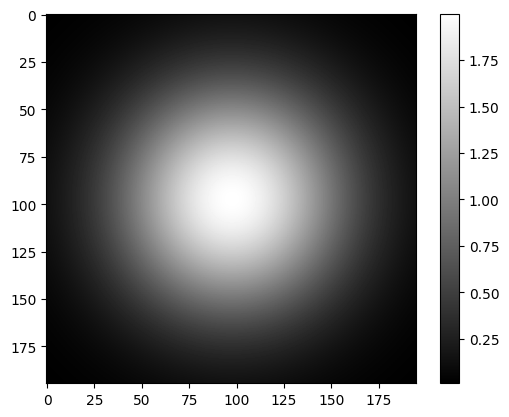

In [11]:
plt.imshow(sigma_matrix,'gray')
plt.colorbar()
plt.show()

In [12]:
def plot_function(img1,img2,title1,title2):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(img1 , 'gray')
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.imshow(img2 , 'gray')
    plt.title(title2)
    plt.show()

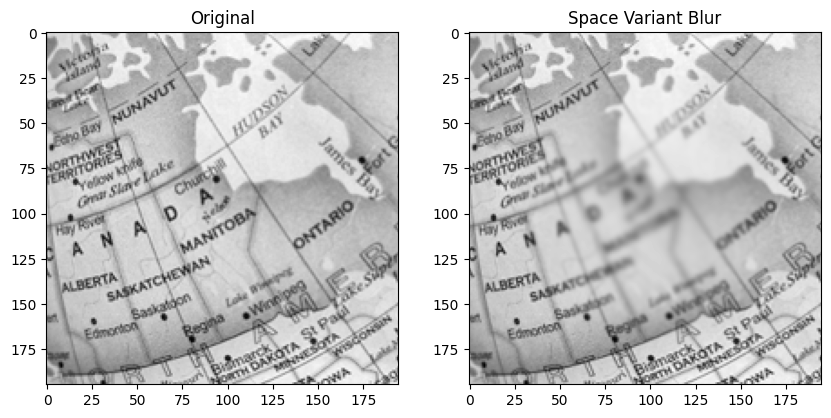

In [13]:
plot_function(img_globe,blurred,title1='Original',title2='Space Variant Blur')

##### Q_2 Nautilus.png

##### Space Invariant Blur 

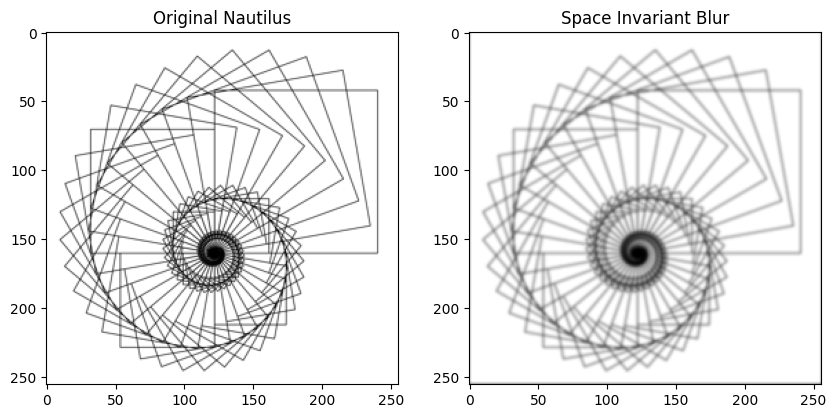

In [14]:
given_sigma = 1.0
sp_inv = convolution_2D(img_nautilus , given_sigma)
plot_function(img_nautilus , sp_inv , 'Original Nautilus' , 'Space Invariant Blur')

##### Space Variant 

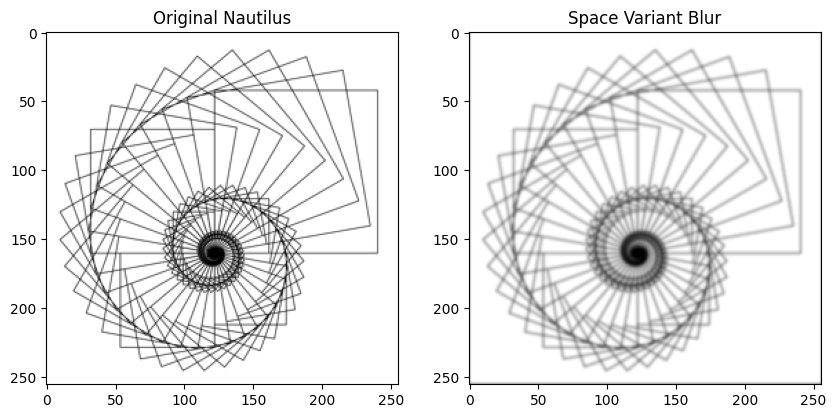

In [15]:
###space variant 
sigma_matrix_2 = np.ones_like(img_nautilus)
sp_var  = space_variant_blur(img_nautilus , sigma_matrix_2)
plot_function(img_nautilus , sp_inv , 'Original Nautilus' , 'Space Variant Blur')

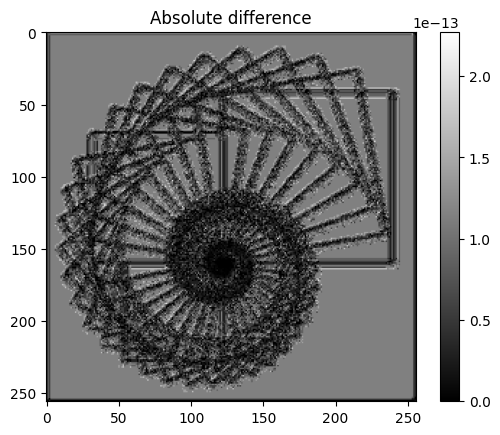

In [16]:
plt.imshow(np.abs(sp_inv-sp_var), 'gray')
plt.title("Absolute difference")
plt.colorbar()
plt.show()

## Conclusion

* Visualization of the sigma matrix gives an intuition how the globe is going to be blurred , this is because of the initial 
condition we have , (N/2,N/2) max at the centre of the image and less as the image goes towards the edges 
* When we change the sigma matrix to a constant , we cannot see much difference between the space variant and invariant images
But the machine is able to give the difference in the order of 10^-13  assuming to the machine precision is  10^-16
* Gaussian Kernel needs to be calculated in the each step , so running Space Varying Blur is taking time shown below.

In [19]:
%%time 
##varying
t1 = space_variant_blur(img_nautilus , sigma_matrix_2)

CPU times: total: 9.7 s
Wall time: 9.78 s


In [20]:
%%time 
t2 = convolution_2D(img_nautilus , given_sigma)

CPU times: total: 375 ms
Wall time: 383 ms
